# 基于神经网络的文本相关声纹识别

In [1]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential, model_from_json
from keras.layers import *
from keras import optimizers

warnings.filterwarnings('ignore')

##### 通过路径返回训练音频列表

In [2]:
# -*- coding: utf-8 -*-
def listdir(path: str, list_name: list):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isdir(file_path):
            listdir(file_path, list_name)
        elif os.path.splitext(file_path)[1] == '.wav':
            list_name.append(file_path)
    return list_name

In [3]:
list_name = list()
list_name = listdir('RawData/CASIA database', list_name)

##### 情感分类标签

In [4]:
label_list = list()
for i in range(len(list_name)):
    name = list_name[i]
    if "angry" in name:
        label_list.append("angry")
    elif "fear" in name:
        label_list.append("fear")
    elif "happy" in name:
        label_list.append("happy")
    elif "neutral" in name:
        label_list.append("neutral")
    elif "sad" in name:
        label_list.append("sad")
    elif "surprise" in name:
        label_list.append("surprise")
    else:
        label_list.append("nothing")
labels = pd.DataFrame(label_list)

##### 加载音频文件，并通过MFCC算法分析其特性

In [5]:
df = pd.DataFrame(columns=['feature'])
bookmark = 0
for index, y in enumerate(list_name):
    #音频导入函数
    # X : 音频的信号值，类型是ndarray,sample_rate : 采样率
    # y 音频路径|sr 采样率（默认22050，但是有重采样的功能）
    # duration 获取音频的时长 |offset 音频读取的时间
    X, sample_rate = librosa.load(y, res_type='kaiser_fast', duration=2.5, sr=22050 * 2, offset=0.5)
    #得到采样率
    sample_rate = np.array(sample_rate)
    # MFCC提取：
    # 并且求取平均值
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    #获取音频特征
    feature = mfccs
    df.loc[bookmark] = [feature]
    bookmark = bookmark + 1

##### 将分析的数据作为feature和label相关联

In [6]:
df = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df, labels], axis=1)
rnewdf = shuffle(newdf)
rnewdf = rnewdf.fillna(0)
rnewdf

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
851,-6.508937,-9.793197,-16.385256,-13.066641,-8.109298,-8.511228,-13.251451,-16.794250,-16.832167,-17.578995,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
735,-17.455046,-16.974424,-17.329624,-17.992680,-20.298107,-21.130716,-21.788603,-19.327547,-17.860067,-15.177332,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
657,-6.705391,-9.596505,-15.160941,-15.453075,-16.096537,-15.935842,-18.929691,-21.028084,-19.334406,-16.864119,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,fear
971,-24.745838,-28.242205,-37.240322,-36.917393,-36.183754,-36.691257,-35.789616,-35.787777,-38.005310,-36.646378,...,-2.311440,-3.408780,-3.296693,-2.669066,-4.113184,-7.435148,-14.330322,-19.845415,-19.568520,fear
128,-5.228240,-9.212255,-21.739147,-22.735643,-24.710480,-23.323679,-21.660488,-21.944715,-22.379429,-23.048052,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,-8.016138,-8.221905,-10.003786,-10.855636,-10.475377,-9.388357,-9.737834,-10.774779,-11.383915,-11.769036,...,-37.467842,-36.902317,-37.735699,-37.706024,-38.355972,-38.447800,-38.365780,-33.502205,-27.415911,fear
90,-0.592518,-2.729388,-12.273861,-15.951568,-13.971008,-14.366334,-15.868758,-16.589882,-16.587173,-18.143248,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,fear
193,-21.616930,-21.640667,-22.563541,-25.090752,-22.519300,-22.450069,-23.910797,-26.672798,-19.973499,-3.240777,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
1069,-9.075784,-8.038444,-8.989592,-8.586917,-8.372378,-8.070036,-8.925899,-12.184606,-18.962801,-24.949606,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [7]:
features = rnewdf.iloc[:, :-1]
labels = rnewdf.iloc[:, -1:]

##### 将数据集分为训练集、验证集和测试集

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size=0.1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True)

##### 训练与测试音频数：864个训练音频，216个验证音频，120个测试音频

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(864, 216)
(216, 216)
(120, 216)
(864, 1)
(216, 1)
(120, 1)


##### 转换成numpy数组或矩阵

In [10]:
lb = LabelEncoder()

X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

##### 构造训练模型

In [11]:
model = Sequential()

model.add(Conv1D(256, 5, padding='same', input_shape=(216, 1)))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', ))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', ))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', ))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()
opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 batch_normalization_1 (Batc  (None, 216, 128)         512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

##### 模型训练

In [13]:
cnnhistory = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
7/7 [==============================] - 7s 738ms/step - loss: 1.9956 - accuracy: 0.1944 - val_loss: 1.7989 - val_accuracy: 0.1574
Epoch 2/200
7/7 [==============================] - 5s 740ms/step - loss: 1.8045 - accuracy: 0.2697 - val_loss: 1.7918 - val_accuracy: 0.1528
Epoch 3/200
7/7 [==============================] - 5s 706ms/step - loss: 1.6967 - accuracy: 0.3194 - val_loss: 1.7873 - val_accuracy: 0.1759
Epoch 4/200
7/7 [==============================] - 5s 700ms/step - loss: 1.6109 - accuracy: 0.3484 - val_loss: 1.7830 - val_accuracy: 0.1898
Epoch 5/200
7/7 [==============================] - 5s 745ms/step - loss: 1.5349 - accuracy: 0.3877 - val_loss: 1.7782 - val_accuracy: 0.2083
Epoch 6/200
7/7 [==============================] - 5s 749ms/step - loss: 1.4776 - accuracy: 0.4201 - val_loss: 1.7748 - val_accuracy: 0.2315
Epoch 7/200
7/7 [==============================] - 5s 741ms/step - loss: 1.4145 - accuracy: 0.4630 - val_loss: 1.7710 - val_accuracy: 0.2315
Epoch 8/200
7

##### 绘制模型的损失函数变化曲线

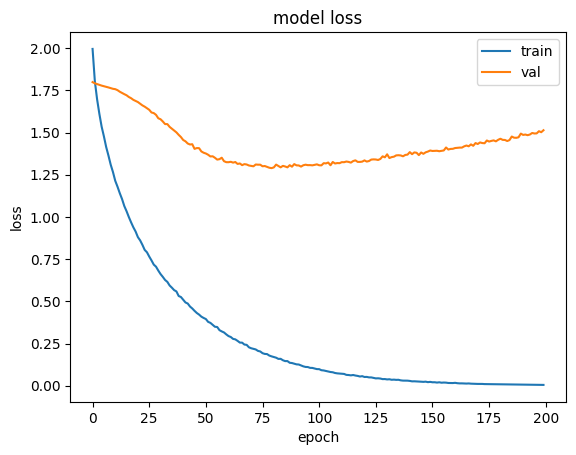

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.savefig("images/loss.png")

##### 绘制模型准确率变化曲线

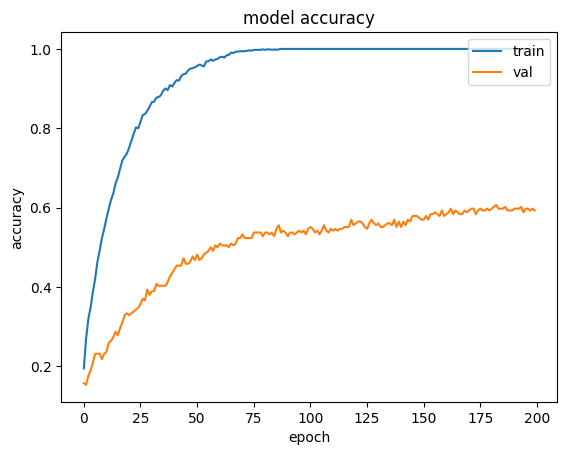

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.savefig("images/accuracy.png")

##### 保存模型结果

In [16]:
model_name = 'model_emotion.h5'
save_dir = os.path.join(os.getcwd(), 'models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
model_json = model.to_json()
with open("models/model_emotion.json", "w") as json_file:
    json_file.write(model_json)

##### 加载模型数据用于测试

In [17]:
json_file = open('models/model_emotion.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("models/model_emotion.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

Loaded model from disk
accuracy: 62.50%


##### 获取预测结果和真实结果

In [18]:
preds = loaded_model.predict(X_test, batch_size=32, verbose=1)
preds = preds.argmax(axis=1)
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform(preds))
preddf = pd.DataFrame({'predictedvalues': preds})
preddf

4/4 [==============================] - 0s 41ms/step


,predictedvalues
0,neutral
1,neutral
2,surprise
3,neutral
4,surprise
...,...
115,angry
116,surprise
117,surprise
118,sad


In [19]:
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform(actual))
actualdf = pd.DataFrame({'actualvalues': actual})
actualdf

,actualvalues
0,happy
1,surprise
2,neutral
3,happy
4,surprise
...,...
115,angry
116,surprise
117,angry
118,sad


In [20]:
finaldf = actualdf.join(preddf)
finaldf

,actualvalues,predictedvalues
0,happy,neutral
1,surprise,neutral
2,neutral,surprise
3,happy,neutral
4,surprise,surprise
...,...,...
115,angry,angry
116,surprise,surprise
117,angry,surprise
118,sad,sad


In [21]:
finaldf.to_csv('result_emotion.csv', index=False)

In [22]:
gc.collect()

8807